# 1. Imports

In [2]:
# our functions
import functions as f
# readers

import gzip
import json

import codecs

import numpy as np

import random

# plot
import matplotlib.pyplot as plt
import scipy.stats as stats

# NN
## early stopping
import h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

## contractions
import sys
!{sys.executable} -m pip install contractions
import contractions
## dictionary
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

# time
from datetime import datetime

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"
PATH["hard_sentences"] = PATH["dataset_classification"] + "hard_sentences.json.gz"

# 2. Read in the files

In [4]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])
hard_sen = f.readJson(PATH["hard_sentences"])

Number of data:  100000
Number of data:  10000
Number of data:  10000


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/classification/hard_sentences.json.gz'

In [5]:
sent_dict = {"positive": 1, "negative": 0}

In [6]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        exp_text = f.concat_and_negation(data[i]["sentiment"])
        train_sent.append(exp_text)
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)
print(train_sent[2])

[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]
negative


number of words in the sentence
47.03345806735637


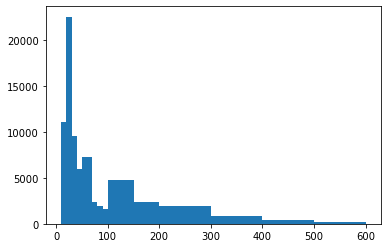

In [7]:
# train data reviews length simple statistic
import matplotlib.pyplot as plt
bins = [10, 20, 30,40,50,70,80,90,100,150,200,300,400,500,600]
plt.hist(length_of_sentencies_counter, bins = bins)
print("number of words in the sentence")
print(np.average(length_of_sentencies_counter))

In [8]:
data = dev
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        exp_text = f.concat_and_negation(data[i]["sentiment"])
        dev_sent.append(exp_text)
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

[]


In [1]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
test_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        exp_text = f.concat_and_negation(data[i]["sentiment"])
        test_sent.append(exp_text)
        test_sentiment.append(data[i]["sentiment"])
        print(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        test_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",test_missing_indexies)

NameError: name 'test' is not defined

In [23]:
data = hard_sen
hard_sen_sent = []
hard_sen_sentiment = []
hard_sen_idx = []
hard_sen_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        hard_sen_sent.append(data[i]["reviewText"])
        hard_sen_sentiment.append(data[i]["sentiment"])
        print(data[i]["sentiment"])
        hard_sen_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        hard_sen_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",hard_sen_missing_indexies)

positive
positive
positive
positive
negative
positive
negative
negative
negative
positive
negative
positive
positive
positive
positive
positive
negative
negative
negative
positive
positive
positive
positive
positive
positive
index of reviews which are empty:  []


In [24]:
# it needs to be replaced since it doesnt handle the lower/upper cases and the mess
###################################################################################
from zeugma import TextsToSequences
sequencer = TextsToSequences()
print(type(sequencer))
sequencer.fit_transform(train_sent)
# save the sequencer  than load it again
import pickle
b = pickle.dumps(sequencer)
pickle.dump( b, open( "model/text_to_seq.p", "wb" ) )
# load 
sequencer = pickle.load( open( "model/text_to_seq.p", "rb" ) )
sequencer = pickle.loads(sequencer)

#print(sequencer.index_word)
# fit new data 
Train = sequencer.transform(train_sent)
Dev = sequencer.transform(dev_sent)
Test = sequencer.transform(test_sent)
Hard_sen = sequencer.transform(hard_sen_sent)

<class 'zeugma.keras_transformers.TextsToSequences'>


In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

## Padding the dataset, POST padding works better a little bit

In [28]:
padding = "post"
maxlen = 50 # how many words from the review
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
X_hard_sen_p = sequence_pad(Hard_sen, padding=padding, maxlen=maxlen)
len(X_test_p)

9993

In [29]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
print(len(X_test_m))
#print(len(y_test_m))
X_hard_sen_m = np.array(X_hard_sen_p)
print(len(X_hard_sen_m))

# sampling some random data for tran and DEV

bias = 50000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
X_valid_m = X_valid_m[s_test:int(e_test)]
y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]
print(len(y_train_m))
print(len(X_train_m))

99946
99946
9996
9996
9993
25
50000
50000


# Early stopping

In [30]:
'''# callback
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#cb = Callback(...)
#cb_list = [cb, ...] # add the callback to a list
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=1) # to continue since maybe we get a local min somewhere'
                   
# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1) # other possibility
# es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4) # based on threshold
# save best models
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
checkpoint_filepath = 'model/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                             patience=3,
                                                             mode='min')

# checkpoint

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='min',
    save_best_only=True)'''

"# callback\n# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/\n#cb = Callback(...)\n#cb_list = [cb, ...] # add the callback to a list\nes = EarlyStopping(monitor='val_loss',\n                  mode='min',\n                  verbose=1,\n                  patience=1) # to continue since maybe we get a local min somewhere'\n                   \n# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1) # other possibility\n# es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4) # based on threshold\n# save best models\n#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)\n#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)\ncheckpoint_filepath = 'model/checkpoint'\nmodel_checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',\n                                                             patience=3,\n                

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            5119488   
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,185,589
Trainable params: 5,185,589
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
3125/3125 [==============================] - 243s 77ms/step - loss: 0.5120 - accuracy: 0.7196 - val_loss: 0.3155 - val_accuracy: 0.8786
Epoch 2/5
3125/3125 [==============================] - 224s 72ms/step - loss: 0.2365 - accuracy: 0.9105 - val_loss: 0.2590 - val_accuracy: 0.8996
Epoch 3/5
312

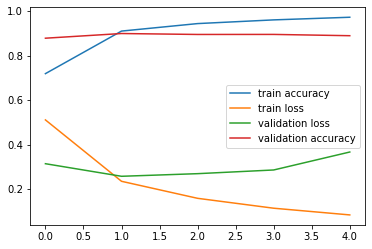

INFO:tensorflow:Assets written to: model/2022-3-29-15-38-59\assets


INFO:tensorflow:Assets written to: model/2022-3-29-15-38-59\assets


In [31]:
vocabulary_size = max(sequencer.index_word)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# get time for saving the model

dateTimeObj = datetime.now()
save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)

# define the model

embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

batch_size = 16
num_epochs = 5

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), 
                    batch_size=batch_size, 
                    epochs=num_epochs)  # for regularization)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
plt.plot(history.history["accuracy"], label='train accuracy')
plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='validation loss')
plt.plot(history.history["val_accuracy"], label='validation accuracy')
plt.legend()
plt.show()
######### ------------------------- ################### save the model
model.save('model/'+save_time)

### Save the model, prediction

In [16]:
#model.save('model/')
result = model.predict(X_test_m)

In [32]:
hard_result = model.predict(X_hard_sen_m)

## Sentiment results, Sampling some guess

In [17]:
threshold = 0.5
acc = 0
acc_count = 0
res_final = []
for r in result:
    acc_count+=1
    if r<threshold:
        r = 0
        res_final.append("negative")
    if r>threshold:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("index", i)
    print("####", res_final[i], "---", test_sent[i])

index 2775
#### positive --- ITS A VERY BEAUTIFUL SONG, ORIGINALLY RECORDED BY CHAVELA Y SU GRUPO EXPRESS BUT LOS TINOS HAVE MADE A MASTERPIECE OF IT, I REALLY LOE THIS VERSION!!, IT SOUNDS GREAT!!!
index 6751
#### negative --- Not for me
index 8138
#### positive --- I don't think that Otis Redding ever made a recording that wasn't Grade AAA, good grief and wow GOOOOD.  "I've Got Dreams to Remember" is all good.
index 3277
#### negative --- A total bulls*** rip-off! I wasn't what was advertised! Shame on the false advertisement!
index 3539
#### negative --- This is only 23 seconds.


In [38]:
threshold = 0.5
acc = 0
acc_count = 0
res_final = []
for r in result:
    acc_count+=1
    if r<threshold:
        r = 0
        res_final.append("negative")
    if r>threshold:
        res_final.append("positive")
        
fault_counter = 0
for i in range(0, 25):
    print("index", i)
    print("####", res_final[i], "---", hard_sen_sent[i])
    if hard_sen_sentiment[i] == res_final[i]:
        print("correct")
    else:
        print("wrong")
        fault_counter += 1
print(fault_counter)

index 0
#### positive --- This album is a riot to listen to
correct
index 1
#### positive --- This CD will enchant anyone
correct
index 2
#### positive --- I was enthralled by the artists unique style
correct
index 3
#### positive --- The artist is truly imaginative with his selection of instruments
correct
index 4
#### negative --- The bagpipe is simply horrendous to listen to
correct
index 5
#### positive --- simply divine
correct
index 6
#### negative --- sounds more like the screech of some eldritch abomination than anything else
correct
index 7
#### positive --- i'd rather listen to the wails of the damned than this
wrong
index 8
#### positive --- I used to love everything composed by this artist, but these latest songs have just been bad overall
wrong
index 9
#### positive --- This song really surprised me with its quality. I hate all of their previous works but this one is just so good.
correct
index 10
#### negative --- I used to listen to this song all day because of how good 

In [18]:
from collections import defaultdict

json_raw_data = []
jsonfilename = 'dataset/classification/tt.gz'
counter = 0
list_of_skip_indexies = [90, 117, 439, 2138, 4112, 5364, 8210]
res_count = 0
for line in gzip.open('dataset/classification/t_masked.gz'):
    review_data = json.loads(line)
    tempdata = []
    if counter in list_of_skip_indexies: # keep origine
        print("keep original")
        print(counter)
        print(review_data)
        res_count -=1
        for key in review_data:
            #print("keep original")
            tempdata.append({
            key: str(review_data[key])})
    else:
        def_dict = defaultdict(list)
        def_dict = dict()
        for key in review_data:
            #print(key)
            if key == "sentiment":
                def_dict[key] = res_final[res_count]
            else:
                tempdata.append({
                key: str(review_data[key])})
                def_dict[key] = str(review_data[key])
    counter += 1
    res_count +=1
    #print(counter)

    #json_raw_data.append(def_dict)
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('music_reviews_test.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

keep original
90
{'verified': False, 'reviewTime': '11 16, 2015', 'reviewerID': 'A1O7C6DFZ15E43', 'asin': 'B007Z2OQB0', 'summary': 'Five Stars', 'unixReviewTime': 1447632000, 'sentiment': '_', 'id': 90}
keep original
117
{'verified': True, 'reviewTime': '07 31, 2017', 'reviewerID': 'AWGJYHMXOYCVI', 'asin': 'B007ZCH8R4', 'unixReviewTime': 1501459200, 'sentiment': '_', 'id': 117}
keep original
439
{'verified': True, 'reviewTime': '08 16, 2016', 'reviewerID': 'A24YYQXR82CKHJ', 'asin': 'B008591TBW', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1471305600, 'sentiment': '_', 'id': 439}
keep original
2138
{'verified': True, 'reviewTime': '09 13, 2016', 'reviewerID': 'A1ZBIIZLWE8NRE', 'asin': 'B00940XFTK', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1473724800, 'sentiment': '_', 'id': 2138}
keep original
4112
{'verified': True, 'reviewTime': '07 4, 2018', 'reviewerID': 'A1K51YDXUGEEBG', 'asin': 'B000YIWSK8', 'unixReviewTime':

In [19]:
for line in gzip.open('group16.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break

FileNotFoundError: [Errno 2] No such file or directory: 'group16.json.gz'